In [1]:
import numpy as np
import onnxruntime as rt
import skbio

In [3]:
sess = rt.InferenceSession('bac120_r202.resnet50.genus.onnx')

In [4]:
sess

In [5]:
input_name = sess.get_inputs()[0].name

In [6]:
path = '/global/cscratch1/sd/azaidi/GCA_000006155.2_ASM615v2_genomic.fna'

In [7]:
def _get_DNA_map():
    '''
    create a DNA map with some redundancy so that we can
    do base-complements with +/% operations.
    Using this scheme, the complement of a base should be:
    (base_integer + 9) % 18
    chars[(basemap[ord('N')]+9)%18]
    For this to work, bases need to be ordered as they are below
    '''
    chars = ('ACYWSKDVN'
             'TGRWSMHBN')
    basemap = np.zeros(128, dtype=np.uint8)
    for i, c in reversed(list(enumerate(chars))):  # reverse so we store the lowest for self-complementary codes
        basemap[ord(c)] = i
        basemap[ord(c.lower())] = i
    return chars, basemap

#this will just pull all the sequences from a fasta file
def get_seqs(path):
    return [seq.values.view(np.uint8) for seq in skbio.io.read(path, format='fasta')]

#this will produce a list featuring chunks of the sequence
def chunk_seq(sequence, size):
    num_windows = len(sequence)//size
    return [sequence[size*i: size*(i+1)] for i in range(num_windows)]

#this will map each item onto our basemap from above
def map_seq(chunked_sequence, basemap):
    return basemap[np.array(chunked_sequence)]#.view(np.uint8)]
    #return basemap[np.vectorize(ord)(np.array(chunked_sequence))]

#this will return the reverse complementary strand    
def get_rev_comp(chunks, chars):
    chars_dict = {i:v for i,v in enumerate(chars)}
    return np.vectorize(chars_dict.get)((chunks + 9) %18)

#combines fxns above into a single array with chunks in both directons
def get_bidir_seq(chunks):
    chars, basemap = _get_DNA_map()
    fwd_chunk_mapped = map_seq(chunks, basemap).astype(int)
    rev_chunked = get_rev_comp(fwd_chunk_mapped, chars)
    rev_chunk_mapped = map_seq(rev_chunked, basemap).astype(int)
    bi_seq = np.append(fwd_chunk_mapped, rev_chunk_mapped, axis=0)
    return bi_seq

In [8]:
sequences = get_seqs(path)
len(sequences)

3

In [9]:
chars, basemap = _get_DNA_map()
chunked_seq = chunk_seq(sequences[1], 4096)
one_seq = map_seq(chunked_seq, basemap)

In [10]:
one_seq

array([[ 9,  0,  9, ...,  9,  0,  1],
       [ 0,  0, 10, ...,  9,  0,  0],
       [ 9,  0,  0, ...,  0,  9, 10],
       ...,
       [10,  9,  9, ...,  0,  9,  1],
       [ 9, 10,  1, ...,  9,  1,  1],
       [ 1,  9,  9, ...,  9,  0,  9]], dtype=uint8)

In [11]:
one_seq[:10].shape

(10, 4096)

In [12]:
one_seq[:, None, :].shape

(44, 1, 4096)

In [23]:
pred_onx = sess.run(None, {input_name: one_seq.astype(np.int64)})[0]
pred_onx.shape

(44, 12037)

In [24]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [25]:
soft_out = softmax(pred_onx)
soft_out.shape

(44, 12037)

In [34]:
soft_out.argmax()

74859

In [33]:
soft_out.mean(axis=0).argmax()

2909

In [41]:
import scipy.special

In [55]:
scipy.special.softmax(pred_onx).shape

(44, 12037)

In [81]:
%%timeit
soft_out = scipy.special.softmax(pred_onx)
soft_out

3.27 ms ± 59 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
import matplotlib.pyplot as plt

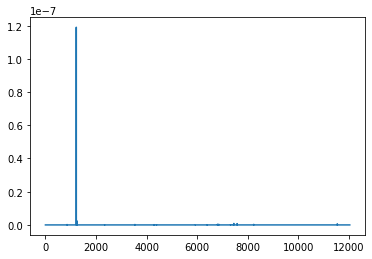

In [59]:
plt.plot(soft_out[0])

In [63]:
soft_out[0].argmax()

1221

In [75]:
#[x.argmax() for x in soft_out]

In [68]:
soft_out.mean(axis=0).shape

(12037,)

In [70]:
soft_out.mean(axis=0).argmax()

1221

In [78]:
def get_prob(x):
    soft_out = scipy.special.softmax(x)
    probabilities = soft_out.mean(axis=0)
    return probabilities

In [79]:
get_prob(pred_onx).shape

(12037,)